In [ ]:
from google.colab import drive
drive.mount('/content/drive')
    

Mounted at /content/drive


In [ ]:
import os
import zipfile
import shutil

local_zip = '/content/drive/MyDrive/Road_lane_dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
os.makedirs('/tmp/train')
zip_ref.extractall('/tmp/train')
zip_ref.close()

In [ ]:
!ls /tmp/train

Road_lane_dataset


In [ ]:
import shutil
import os
import glob

import matplotlib.pyplot as plt
import random
import numpy as np
from collections import OrderedDict

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# import morph
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
#train_on_gpu = False

if not train_on_gpu:
    device = 'cpu'
    print('CUDA is not available.  Training on CPU ...')
else:
    device = 'cuda'
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
data_dir = '/tmp/train/Road_lane_dataset'
transform = transforms.Compose([
    transforms.ToTensor(),
    ])
train_data_mean = datasets.ImageFolder(data_dir, transform= transforms.ToTensor())

rgb_mean = [np.mean(x.numpy(), axis=(1,2)) for x,_ in train_data_mean]
rgb_std = [np.std(x.numpy(), axis=(1,2)) for x,_ in train_data_mean]


# 각 데이터 채널별로 mean, std 나타내기
c_mean = []
c_std = []
for i in range(3):
    c_mean.append(np.mean([m[i] for m in rgb_mean]))
    c_std.append(np.std([s[i] for s in rgb_std]))
    
print(f'rgb mean: {c_mean}\nrgb std: {c_std}')

rgb mean: [0.4083593, 0.38350013, 0.3558106]
rgb std: [0.048815574, 0.047716994, 0.047191493]


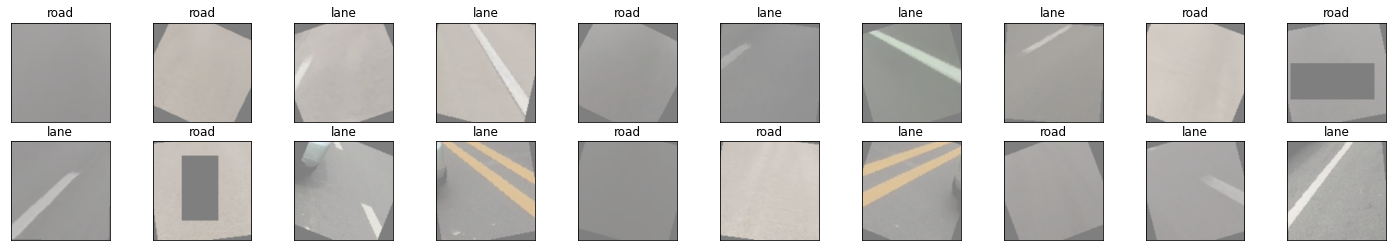

In [ ]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size =  128
data_dir = '/tmp/train/Road_lane_dataset'

classes = ['lane', 'road']


transform = transforms.Compose([
    transforms.ColorJitter(brightness=(0.8, 1.2)),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop((224,224),scale=(0.8,1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.1)
    ])
train_data = datasets.ImageFolder(data_dir, transform=transform)

valid_size = 0.2

num_train = len(train_data)
num_train = int(num_train)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))                      
train_idx, valid_idx = indices[split:], indices[:split]


# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers, drop_last = True)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers, drop_last = True)

import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])


In [ ]:
import torch.nn.functional as F
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        nn.init.kaiming_normal_(self.conv1.weight.data,nonlinearity ='leaky_relu')

        self.conv2= nn.Conv2d(16, 16, 3, stride=1, padding=1)
        nn.init.kaiming_normal_(self.conv2.weight.data,nonlinearity ='leaky_relu')

        self.conv3= nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.conv4= nn.Conv2d(32, 32, 3, stride=1, padding=1)
        nn.init.kaiming_normal_(self.conv3.weight.data,nonlinearity ='leaky_relu')
        nn.init.kaiming_normal_(self.conv4.weight.data,nonlinearity ='leaky_relu')

        self.conv5= nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.conv6= nn.Conv2d(64, 64, 3, stride=1, padding=1)
        nn.init.kaiming_normal_(self.conv5.weight.data,nonlinearity ='leaky_relu')
        nn.init.kaiming_normal_(self.conv6.weight.data,nonlinearity ='leaky_relu')

        self.conv7= nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv8= nn.Conv2d(64, 128, 3, stride=1, padding=1)
        nn.init.kaiming_normal_(self.conv7.weight.data,nonlinearity ='leaky_relu')
        nn.init.kaiming_normal_(self.conv8.weight.data,nonlinearity ='leaky_relu')

        self.conv9= nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv10= nn.Conv2d(128, 128, 3, stride=1, padding=1)
        nn.init.kaiming_normal_(self.conv9.weight.data,nonlinearity ='leaky_relu')
        nn.init.kaiming_normal_(self.conv10.weight.data,nonlinearity ='leaky_relu')

        self.conv11= nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv12= nn.Conv2d(128, 128, 3, stride=1, padding=1)
        nn.init.kaiming_normal_(self.conv11.weight.data,nonlinearity ='leaky_relu')
        nn.init.kaiming_normal_(self.conv12.weight.data,nonlinearity ='leaky_relu')

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(1152, 512)
        nn.init.kaiming_normal_(self.fc1.weight.data,nonlinearity ='leaky_relu')

        self.fc2 = nn.Linear(512, 128)
        nn.init.kaiming_normal_(self.fc2.weight.data,nonlinearity ='leaky_relu')

        self.fc3 = nn.Linear(128, 32)
        nn.init.kaiming_normal_(self.fc3.weight.data,nonlinearity ='leaky_relu')

        self.fc4 = nn.Linear(32, 2)
        nn.init.kaiming_normal_(self.fc4.weight.data,nonlinearity ='leaky_relu')

        self.dropout1= nn.Dropout(0.2)
        self.dropout2= nn.Dropout(0.25)
        self.dropout3= nn.Dropout(0.35)
        self.dropout4= nn.Dropout(0.4)
        self.dropout5= nn.Dropout(0.45)
        self.dropout6= nn.Dropout(0.5)
        
        self.relu = nn.LeakyReLU(0.2)
        self.softmax = nn.Softmax(True)
        
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.bn2 = torch.nn.BatchNorm2d(16)
        self.bn3 = torch.nn.BatchNorm2d(32)
        self.bn4 = torch.nn.BatchNorm2d(32)
        self.bn5 = torch.nn.BatchNorm2d(64)
        self.bn6 = torch.nn.BatchNorm2d(64)
        self.bn7 = torch.nn.BatchNorm2d(64)
        self.bn8 = torch.nn.BatchNorm2d(128)
        self.bn9 = torch.nn.BatchNorm2d(128)
        self.bn10 = torch.nn.BatchNorm2d(128)
        self.bn11 = torch.nn.BatchNorm2d(128)
        self.bn12 = torch.nn.BatchNorm2d(128)

        self.bn20 = torch.nn.BatchNorm1d(512)
        self.bn21 = torch.nn.BatchNorm1d(512)
        self.bn22 = torch.nn.BatchNorm1d(128)
        self.bn23 = torch.nn.BatchNorm1d(32)
        self.bn24 = torch.nn.BatchNorm1d(2)
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        
        
        x = self.conv1(x)
        x = self.bn1(x)  
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)  
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = self.bn3(x)  
        x = self.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)  
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout2(x)

        x = self.conv5(x)
        x = self.bn5(x)  
        x = self.relu(x)
        x = self.conv6(x)
        x = self.bn6(x)  
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout2(x)

        x = self.conv7(x)
        x = self.bn7(x)  
        x = self.relu(x)
        x = self.conv8(x)
        x = self.bn8(x)  
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout3(x)


        x = self.conv9(x)
        x = self.bn9(x)  
        x = self.relu(x)
        x = self.conv10(x)
        x = self.bn10(x)  
        x = self.relu(x)

        x = self.conv11(x)
        x = self.bn11(x)  
        x = self.relu(x)
        x = self.conv12(x)
        x = self.bn12(x)  
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout3(x)

        #print(x.shape)
        x = x.view(x.shape[0], -1)

        #x = self.bn20(x)

        x = self.fc1(x)
        x = self.bn21(x)
        x = self.relu(x)
        x = self.dropout4(x)

        x = self.fc2(x)
        x = self.bn22(x)
        x = self.relu(x)
        x = self.dropout5(x)
        
        x = self.fc3(x)
        x = self.bn23(x)
        x = self.relu(x)
        x = self.dropout6(x)

        x = self.fc4(x)
        x = self.bn24(x)

        return x

model = ConvNet()

# move tensors to GPU if CUDA is available
model.to(device)


ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [ ]:
from torchsummary import summary as summary_
summary_(model,(3,224,224),batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 16, 224, 224]             448
       BatchNorm2d-2        [128, 16, 224, 224]              32
         LeakyReLU-3        [128, 16, 224, 224]               0
         MaxPool2d-4        [128, 16, 112, 112]               0
           Dropout-5        [128, 16, 112, 112]               0
            Conv2d-6        [128, 16, 112, 112]           2,320
       BatchNorm2d-7        [128, 16, 112, 112]              32
         LeakyReLU-8        [128, 16, 112, 112]               0
         MaxPool2d-9          [128, 16, 56, 56]               0
          Dropout-10          [128, 16, 56, 56]               0
           Conv2d-11          [128, 32, 56, 56]           4,640
      BatchNorm2d-12          [128, 32, 56, 56]              64
        LeakyReLU-13          [128, 32, 56, 56]               0
           Conv2d-14          [128, 32,

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4 )
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0.0001)

In [ ]:

n_epochs = 100

valid_loss_min = np.Inf # track change in validation loss

# keep track of training and validation loss
train_loss = torch.zeros(n_epochs)
valid_loss = torch.zeros(n_epochs)

train_acc = torch.zeros(n_epochs)
valid_acc = torch.zeros(n_epochs)

    
for e in range(0, n_epochs):

    ###################
    # train the model #
    ###################
    model.train()
    for data, labels in train_loader:
        # move tensors to GPU if CUDA is available
        data, labels = data.to(device), labels.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        logits = model(data)
        # calculate the batch loss
        loss = criterion(logits, labels)
        # backward pass: compute of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss[e] += loss.item()

        ps = F.softmax(logits, dim=1)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.reshape(top_class.shape)
        train_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()

    train_loss[e] /= len(train_loader)
    train_acc[e] /= len(train_loader)


    ######################    
    # validate the model #
    ######################
    with torch.no_grad(): 
        model.eval()
        for data, labels in valid_loader:
            # move tensors to GPU if CUDA is available
            data, labels = data.to(device), labels.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            logits = model(data).to(device)
            # calculate the batch loss
            loss = criterion(logits, labels)
            # update average validation loss 
            
            valid_loss[e] += loss.item()
            scheduler.step()
            ps = F.softmax(logits, dim=1)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.reshape(top_class.shape)
            valid_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
    
    
    # calculate average losses
    valid_loss[e] /= len(valid_loader)
    valid_acc[e] /= len(valid_loader)

    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss[e], valid_loss[e]))

    # print training/validation statistics 
    print('Epoch: {} \tTraining accuracy: {:.6f} \tValidation accuracy: {:.6f}'.format(
        e, train_acc[e], valid_acc[e]))

    # save model if validation loss has decreased
    if valid_loss[e] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss[e]))
        torch.save(model.state_dict(), '/content/drive/MyDrive/model_road.pt')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
        valid_loss_min = valid_loss[e]




Epoch: 0 	Training Loss: 0.672849 	Validation Loss: 1.395754
Epoch: 0 	Training accuracy: 0.628528 	Validation accuracy: 0.386161
Validation loss decreased (inf --> 1.395754).  Saving model ...
Epoch: 1 	Training Loss: 0.430491 	Validation Loss: 1.122632
Epoch: 1 	Training accuracy: 0.827621 	Validation accuracy: 0.637277
Validation loss decreased (1.395754 --> 1.122632).  Saving model ...
Epoch: 2 	Training Loss: 0.340996 	Validation Loss: 0.477701
Epoch: 2 	Training accuracy: 0.890121 	Validation accuracy: 0.824777
Validation loss decreased (1.122632 --> 0.477701).  Saving model ...
Epoch: 3 	Training Loss: 0.298054 	Validation Loss: 0.330662
Epoch: 3 	Training accuracy: 0.916835 	Validation accuracy: 0.888393
Validation loss decreased (0.477701 --> 0.330662).  Saving model ...
Epoch: 4 	Training Loss: 0.263752 	Validation Loss: 0.291320
Epoch: 4 	Training accuracy: 0.933972 	Validation accuracy: 0.910714
Validation loss decreased (0.330662 --> 0.291320).  Saving model ...
Epoch: 5 	

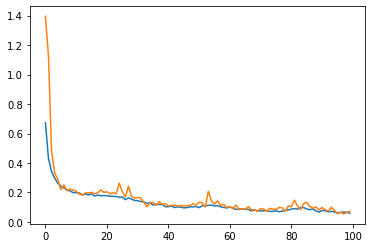

In [ ]:

model.load_state_dict(torch.load('/content/drive/MyDrive/model_cifar.pt97'))

import matplotlib.pyplot as plt

plt.plot(train_loss[:100])
plt.plot(valid_loss[:100])


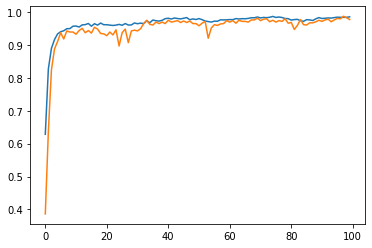

In [ ]:
plt.plot(train_acc[:100])
plt.plot(valid_acc[:100])

In [ ]:
model

In [ ]:
test_dir = '/content/drive/MyDrive/road_lane_test_2'

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
    ])
test_data = datasets.ImageFolder(test_dir, transform=transform)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=3, num_workers=num_workers)

In [ ]:
with torch.no_grad(): 
    model.eval()
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)

        logits = model(data).to(device)
        loss = criterion(logits, labels)
        
        ps = F.softmax(logits, dim=1)
        print(ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.reshape(top_class.shape)
        print(torch.mean(equals.type(torch.float)).detach().cpu())


tensor([[0.1983, 0.8017],
        [0.0532, 0.9468],
        [0.0133, 0.9867]], device='cuda:0')
tensor(0.3333)


In [ ]:
dummy_input = torch.randn(1, 3, 224, 224, device="cuda")

input_names = [ "actual_input_1" ] + [ "learned_%d" % i for i in range(16) ]
output_names = [ "output1" ]

torch.onnx.export(model, dummy_input, "model.onnx", verbose=True, input_names=input_names, output_names=output_names)

graph(%actual_input_1 : Float(1, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cuda:0),
      %fc1.weight : Float(512, 1152, strides=[1152, 1], requires_grad=1, device=cuda:0),
      %fc1.bias : Float(512, strides=[1], requires_grad=1, device=cuda:0),
      %fc2.weight : Float(128, 512, strides=[512, 1], requires_grad=1, device=cuda:0),
      %fc2.bias : Float(128, strides=[1], requires_grad=1, device=cuda:0),
      %fc3.weight : Float(32, 128, strides=[128, 1], requires_grad=1, device=cuda:0),
      %fc3.bias : Float(32, strides=[1], requires_grad=1, device=cuda:0),
      %fc4.weight : Float(2, 32, strides=[32, 1], requires_grad=1, device=cuda:0),
      %fc4.bias : Float(2, strides=[1], requires_grad=1, device=cuda:0),
      %bn21.weight : Float(512, strides=[1], requires_grad=1, device=cuda:0),
      %bn21.bias : Float(512, strides=[1], requires_grad=1, device=cuda:0),
      %bn21.running_mean : Float(512, strides=[1], requires_grad=0, device=cuda:0),
      %b

In [ ]:
!git clone https://github.com/onnx/onnx-tensorflow.git
%cd onnx-tensorflow
!pip3 install .

fatal: destination path 'onnx-tensorflow' already exists and is not an empty directory.
/content/onnx-tensorflow
Processing /content/onnx-tensorflow
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for onnx-tf: filename=onnx_tf-1.9.0-py3-none-any.whl size=225896 sha256=3ccafcbe01990bb2c84161aafbb3d2b70e36839c4126f90f3b1b23b31215f499
  Stored in directory: /root/.cache/pip/wheels/f4/1c/63/cae305ea8da5ff4cd8e2468cfb6201fb036aef41e01261d5c2
Successfully built onnx-tf
  Attempting uninstall: onnx-tf
    Found existing installation: onnx-tf 1.9.0
    Uninstalling onnx-tf-1.9.0:
      Successfully uninstalled onnx-tf-1.9.0


In [ ]:
%cd ..

/content


In [ ]:
from onnx_tf.backend import prepare
import onnx

TF_PATH = "./my_tf_model.pb" 
ONNX_PATH = "./model.onnx" 
onnx_model = onnx.load(ONNX_PATH) 


tf_rep = prepare(onnx_model)  

tf_rep.export_graph(TF_PATH)

INFO:tensorflow:Assets written to: ./my_tf_model.pb/assets


INFO:tensorflow:Assets written to: ./my_tf_model.pb/assets


In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model('/content/my_tf_model.pb') # path to the SavedModel directory
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)